# Spliting: train, val, test

## Second Model : Inspection-Resnet50 v2

### First Data : Training Inspection-Resnet50 v2 on cell_hue segmented data

Epoch 1/50
110/110 [==============================] - 706s 6s/step - loss: 0.4005 - accuracy: 0.8563 - val_loss: 0.2121 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 2/50
110/110 [==============================] - 630s 6s/step - loss: 0.1694 - accuracy: 0.9434 - val_loss: 0.1490 - val_accuracy: 0.9520 - lr: 1.0000e-04
Epoch 3/50
110/110 [==============================] - 648s 6s/step - loss: 0.1155 - accuracy: 0.9631 - val_loss: 0.1114 - val_accuracy: 0.9653 - lr: 1.0000e-04
Epoch 4/50
110/110 [==============================] - 687s 6s/step - loss: 0.0877 - accuracy: 0.9717 - val_loss: 0.1417 - val_accuracy: 0.9480 - lr: 1.0000e-04
Epoch 5/50
110/110 [==============================] - 572s 5s/step - loss: 0.0787 - accuracy: 0.9760 - val_loss: 0.1080 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 6/50
110/110 [==============================] - 510s 5s/step - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.1092 - val_accuracy: 0.9653 - lr: 1.0000e-04
Epoch 7/50
110/110 [====================

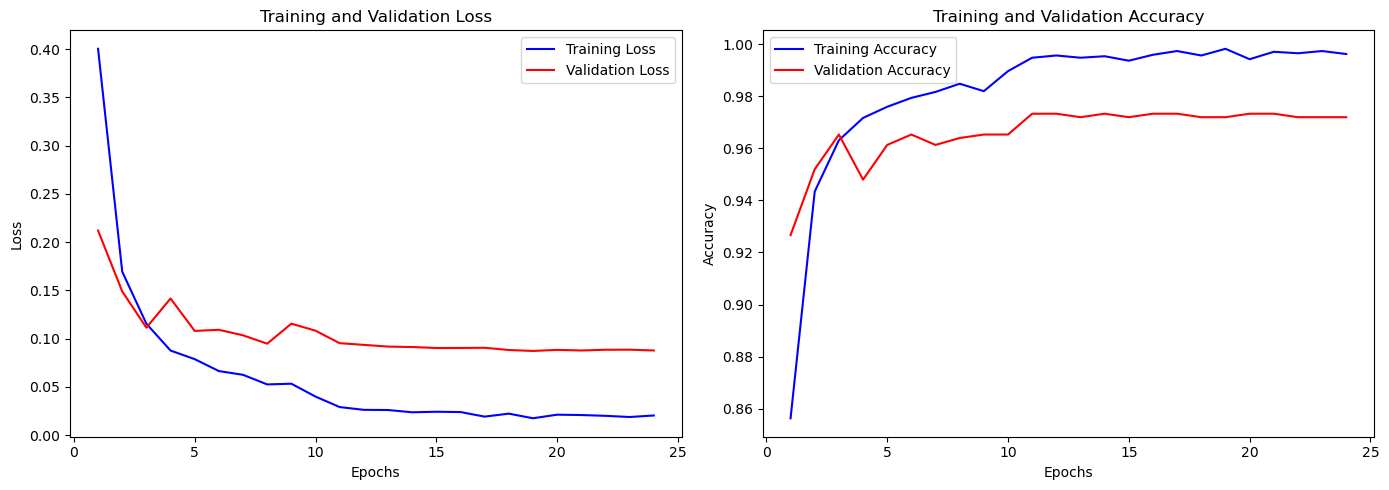

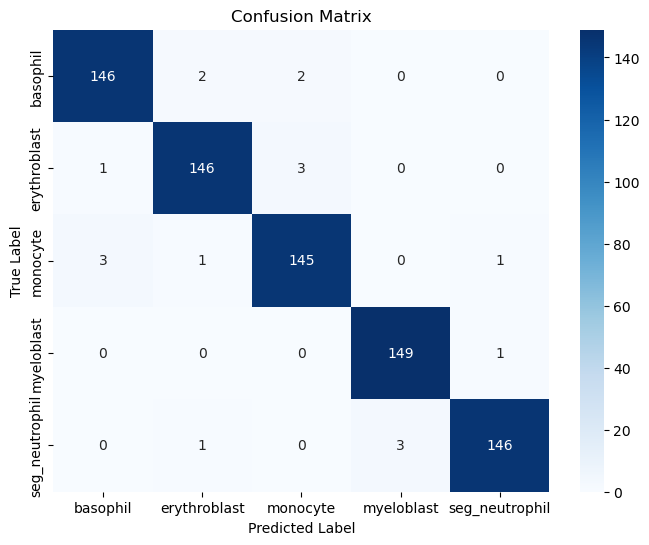

Model saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\cell_hue\Cell_hue_inceptionresnet_model.h5
Training history saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\cell_hue\Cell_hue_inceptionresnet_history.npz


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Load preprocessed data ===
method = "cell_hue"  # change to the desired segmentation method
root = r"C:\Users\Enas Emad\Documents\AML\numpy_encoded"
X = np.load(os.path.join(root, method, "X.npy"))  # Already normalized [0, 1]
y = np.load(os.path.join(root, method, "y.npy"))
class_names = np.load(os.path.join(root, method, "class_names.npy"))

# === Resize to (139, 139, 3) ===
X_resized = tf.image.resize(X, (139, 139)).numpy()

# === Train/Val/Test Split ===
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# === One-hot encode labels ===
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# === Build InceptionResNetV2 model ===
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_callback],
    verbose=1
)

# === Evaluation ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# === Classification Report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# === Accuracy & Loss Curves ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === Save model and history ===
model_save_path = os.path.join(root, method, "Cell_hue_inceptionresnet_model.h5")
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

history_save_path = os.path.join(root, method, "Cell_hue_inceptionresnet_history.npz")
np.savez(history_save_path,
         loss=history.history['loss'],
         val_loss=history.history['val_loss'],
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'])
print(f"Training history saved to: {history_save_path}")


# Spliting: train, val, test

## Second Model : Inspection-Resnet50 v2

### Second Data : Training Inspection-Resnet50 v2 on cell_otsu_dilation segmented data

Epoch 1/50
110/110 [==============================] - 396s 3s/step - loss: 0.4050 - accuracy: 0.8620 - val_loss: 0.2569 - val_accuracy: 0.9067 - lr: 1.0000e-04
Epoch 2/50
110/110 [==============================] - 418s 4s/step - loss: 0.1746 - accuracy: 0.9431 - val_loss: 0.1584 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 3/50
110/110 [==============================] - 457s 4s/step - loss: 0.1070 - accuracy: 0.9626 - val_loss: 0.1190 - val_accuracy: 0.9627 - lr: 1.0000e-04
Epoch 4/50
110/110 [==============================] - 456s 4s/step - loss: 0.0824 - accuracy: 0.9786 - val_loss: 0.1220 - val_accuracy: 0.9653 - lr: 1.0000e-04
Epoch 5/50
110/110 [==============================] - 421s 4s/step - loss: 0.0654 - accuracy: 0.9791 - val_loss: 0.1270 - val_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 6/50
110/110 [==============================] - 454s 4s/step - loss: 0.0499 - accuracy: 0.9863 - val_loss: 0.1261 - val_accuracy: 0.9627 - lr: 1.0000e-04
Epoch 7/50
110/110 [====================

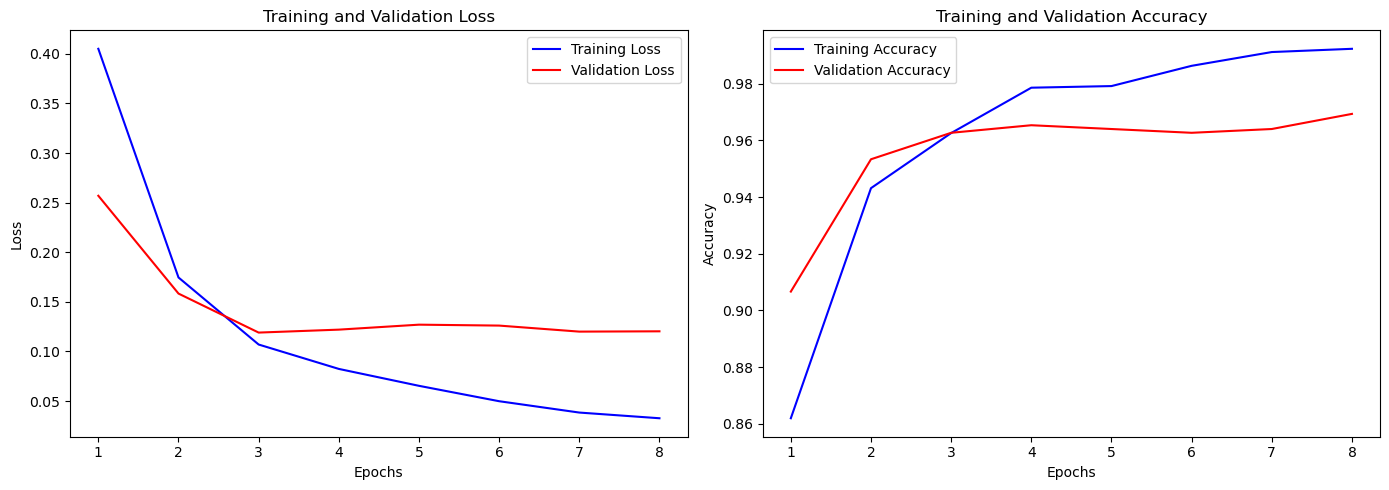

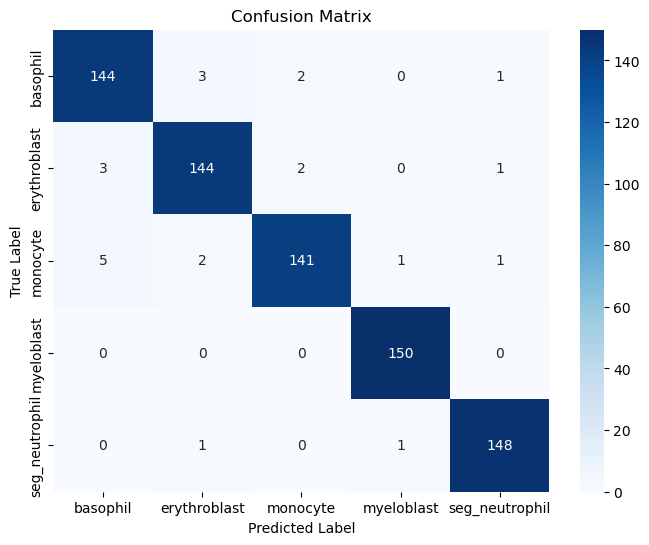

Model saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\cell_otsu_dilation\cell_otsu_dilation_inceptionresnet_model.h5
Training history saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\cell_otsu_dilation\cell_otsu_dilation_inceptionresnet_history.npz


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Load preprocessed data ===
method = "cell_otsu_dilation"  # change to the desired segmentation method
root = r"C:\Users\Enas Emad\Documents\AML\numpy_encoded"
X = np.load(os.path.join(root, method, "X.npy"))  # Already normalized [0, 1]
y = np.load(os.path.join(root, method, "y.npy"))
class_names = np.load(os.path.join(root, method, "class_names.npy"))

# === Resize to (139, 139, 3) ===
X_resized = tf.image.resize(X, (139, 139)).numpy()

# === Train/Val/Test Split ===
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# === One-hot encode labels ===
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# === Build InceptionResNetV2 model ===
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_callback],
    verbose=1
)

# === Evaluation ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# === Classification Report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# === Accuracy & Loss Curves ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === Save model and history ===
model_save_path = os.path.join(root, method, "cell_otsu_dilation_inceptionresnet_model.h5")
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

history_save_path = os.path.join(root, method, "cell_otsu_dilation_inceptionresnet_history.npz")
np.savez(history_save_path,
         loss=history.history['loss'],
         val_loss=history.history['val_loss'],
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'])
print(f"Training history saved to: {history_save_path}")


# Spliting: train, val, test

## Second Model : Inspection-Resnet50 v2

### Third Data : Training Inspection-Resnet50 v2 on nucleus_hue_channel segmented data

Epoch 1/50
110/110 [==============================] - 565s 5s/step - loss: 0.4315 - accuracy: 0.8494 - val_loss: 0.2326 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 2/50
110/110 [==============================] - 471s 4s/step - loss: 0.2052 - accuracy: 0.9349 - val_loss: 0.1863 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 3/50
110/110 [==============================] - 473s 4s/step - loss: 0.1565 - accuracy: 0.9457 - val_loss: 0.1666 - val_accuracy: 0.9480 - lr: 1.0000e-04
Epoch 4/50
110/110 [==============================] - 471s 4s/step - loss: 0.1192 - accuracy: 0.9651 - val_loss: 0.1542 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 5/50
110/110 [==============================] - 473s 4s/step - loss: 0.1038 - accuracy: 0.9669 - val_loss: 0.1651 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 6/50
110/110 [==============================] - 443s 4s/step - loss: 0.0895 - accuracy: 0.9683 - val_loss: 0.1588 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 7/50
110/110 [====================

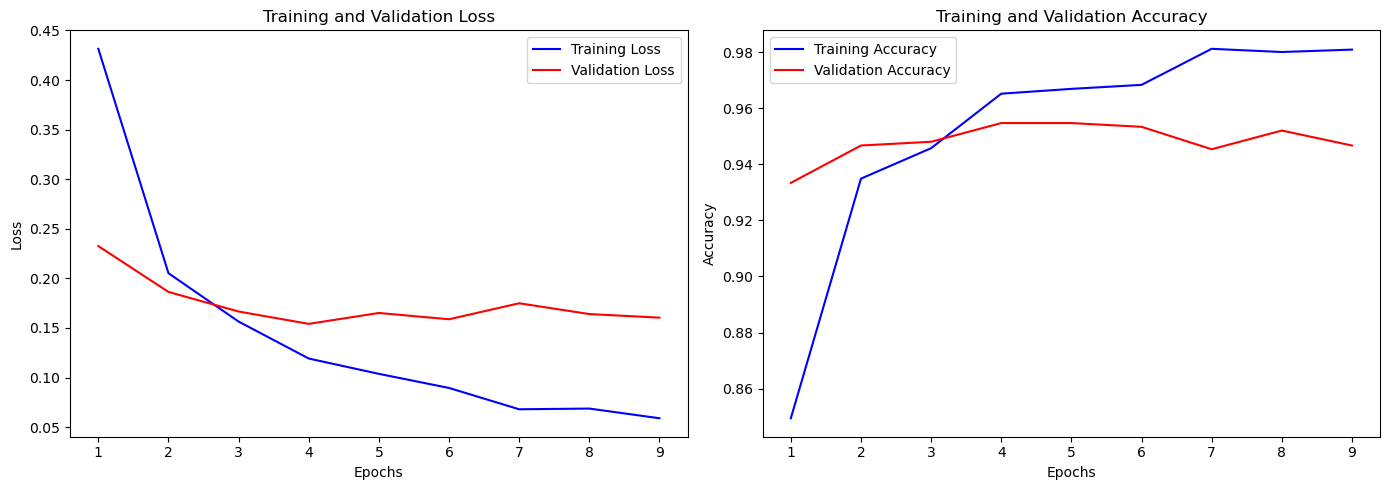

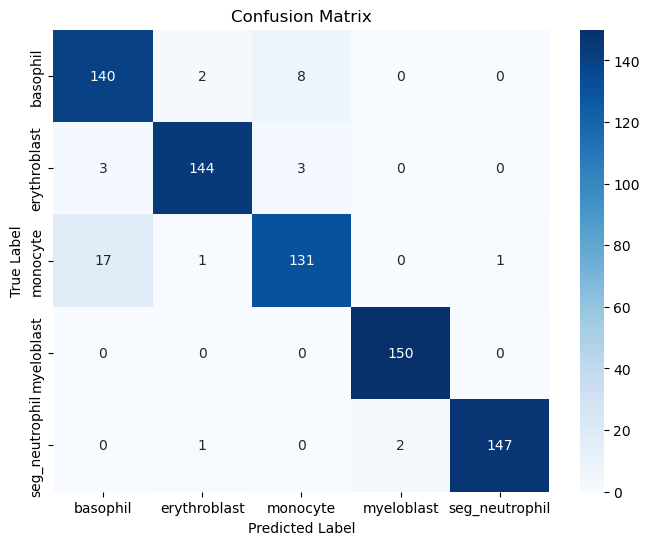

Model saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\nucleus_hue_channel\nucleus_hue_channel_inceptionresnet_model.h5
Training history saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\nucleus_hue_channel\nucleus_hue_channel_inceptionresnet_history.npz


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Load preprocessed data ===
method = "nucleus_hue_channel"  # change to the desired segmentation method
root = r"C:\Users\Enas Emad\Documents\AML\numpy_encoded"
X = np.load(os.path.join(root, method, "X.npy"))  # Already normalized [0, 1]
y = np.load(os.path.join(root, method, "y.npy"))
class_names = np.load(os.path.join(root, method, "class_names.npy"))

# === Resize to (139, 139, 3) ===
X_resized = tf.image.resize(X, (139, 139)).numpy()

# === Train/Val/Test Split ===
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# === One-hot encode labels ===
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# === Build InceptionResNetV2 model ===
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_callback],
    verbose=1
)

# === Evaluation ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# === Classification Report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# === Accuracy & Loss Curves ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === Save model and history ===
model_save_path = os.path.join(root, method, "nucleus_hue_channel_inceptionresnet_model.h5")
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

history_save_path = os.path.join(root, method, "nucleus_hue_channel_inceptionresnet_history.npz")
np.savez(history_save_path,
         loss=history.history['loss'],
         val_loss=history.history['val_loss'],
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'])
print(f"Training history saved to: {history_save_path}")


# Spliting: train, val, test

## Second Model : Inspection-Resnet50 v2

### Fourth Data : Training Inspection-Resnet50 v2 on nucleus_otsu segmented data

Epoch 1/50
110/110 [==============================] - 316s 3s/step - loss: 0.3744 - accuracy: 0.8700 - val_loss: 0.1688 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 2/50
110/110 [==============================] - 282s 3s/step - loss: 0.1536 - accuracy: 0.9474 - val_loss: 0.1454 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 3/50
110/110 [==============================] - 278s 3s/step - loss: 0.1051 - accuracy: 0.9646 - val_loss: 0.1418 - val_accuracy: 0.9493 - lr: 1.0000e-04
Epoch 4/50
110/110 [==============================] - 276s 3s/step - loss: 0.0846 - accuracy: 0.9717 - val_loss: 0.1351 - val_accuracy: 0.9507 - lr: 1.0000e-04
Epoch 5/50
110/110 [==============================] - 278s 3s/step - loss: 0.0667 - accuracy: 0.9797 - val_loss: 0.1311 - val_accuracy: 0.9587 - lr: 1.0000e-04
Epoch 6/50
110/110 [==============================] - 277s 3s/step - loss: 0.0559 - accuracy: 0.9840 - val_loss: 0.1456 - val_accuracy: 0.9493 - lr: 1.0000e-04
Epoch 7/50
110/110 [====================

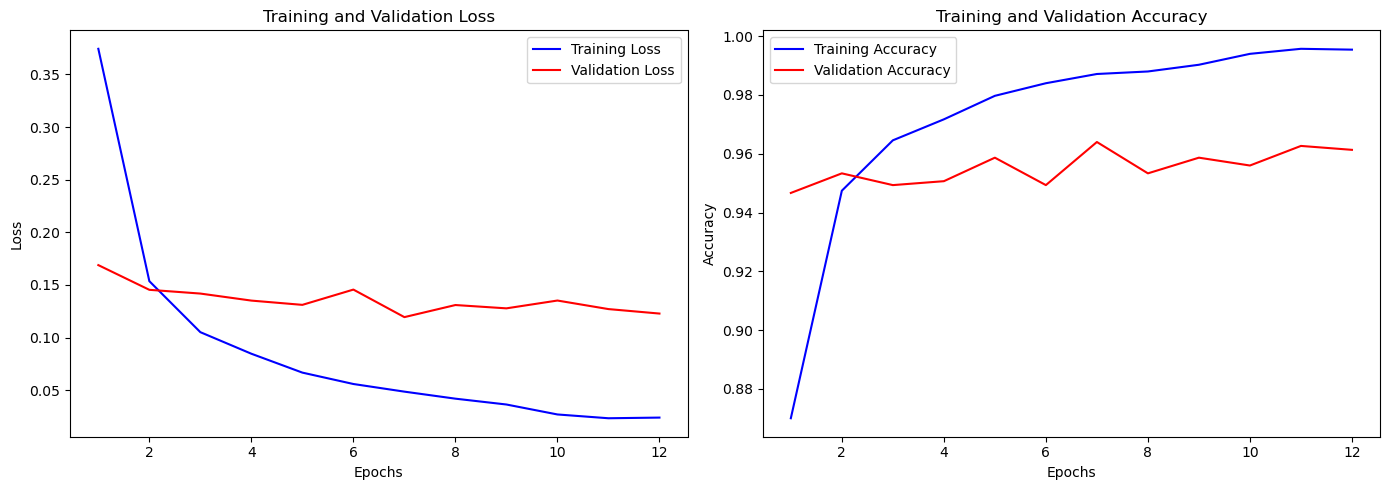

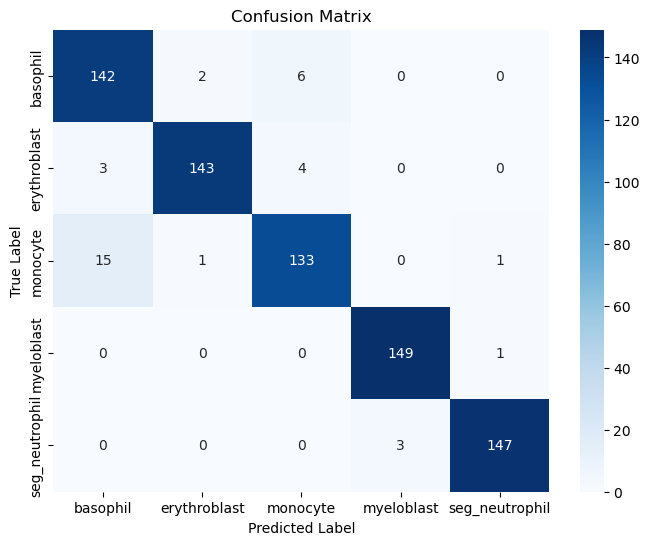

Model saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\nucleus_otsu\nucleus_otsu_inceptionresnet_model.h5
Training history saved to: C:\Users\Enas Emad\Documents\AML\numpy_encoded\nucleus_otsu\nucleus_otsu_inceptionresnet_history.npz


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Load preprocessed data ===
method = "nucleus_otsu"  # change to the desired segmentation method
root = r"C:\Users\Enas Emad\Documents\AML\numpy_encoded"
X = np.load(os.path.join(root, method, "X.npy"))  # Already normalized [0, 1]
y = np.load(os.path.join(root, method, "y.npy"))
class_names = np.load(os.path.join(root, method, "class_names.npy"))

# === Resize to (139, 139, 3) ===
X_resized = tf.image.resize(X, (139, 139)).numpy()

# === Train/Val/Test Split ===
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# === One-hot encode labels ===
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# === Build InceptionResNetV2 model ===
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_callback],
    verbose=1
)

# === Evaluation ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# === Classification Report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# === Accuracy & Loss Curves ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === Save model and history ===
model_save_path = os.path.join(root, method, "nucleus_otsu_inceptionresnet_model.h5")
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

history_save_path = os.path.join(root, method, "nucleus_otsu_inceptionresnet_history.npz")
np.savez(history_save_path,
         loss=history.history['loss'],
         val_loss=history.history['val_loss'],
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'])
print(f"Training history saved to: {history_save_path}")
